## Fog Density Classification and Generalization Capacity of Convolutional Neural Networks

In this notebook I evaluate the performance of the Inception v3 convolutional neural network that has been trained on De Bilt and Cabauw datasets. I test their intra-site performance, but also their inter-site performance to see how well this network generalizes over a small domain shift. 

In this notebook I dedicate a small section to the k-Nearest Neighbors algorithm. This algorithm simply looks at the distances between images and predicts the most prevalent class of the nearest images. It is used as a lower-bound to compare performances with the CNN models.

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import load_model
from keras.utils import np_utils
import numpy as np
import pandas as pd
import cv2
import glob
import os
# To install the packages I created a conda environment with Miniconda3. 
# cv2 is tricky to install but (with the environment loaded) it can 
# easily be installed with the command: 
# conda install -c https://conda.binstar.org/menpo opencv

''' Specify the paths to the data.
'''
train_dir = '../../../thesis/Testing/'


''' Get image metadata

These few lines of code parse the ImageDescription2.csv for information such as image ID, 
y-values and image names.
'''
meta = pd.read_csv(train_dir + 'ImageDescription2.csv')
imgID = meta['image_id'].values
y = pd.Series(meta['vis_class']).astype('category', categories=list('ABCD')).cat.codes
basenames = meta['basename'].values


''' Define helper functions.

process_img() inputs a path to an image, for example /home/user/data/Meetterein_20161021_0750.jpg. It 
performs basic processing to the image: reading it as 3D matrix, resizing it to 3x299x299. 299 is the required 
as the neural network architecture is built on these dimensions.

load_data() inputs the directory where the data is stored and the y values, for example /home/user/data/. 
It loads and processes all images in the directory, transposes the matrices to dimensions the network likes
to work with (keras with tensorflow backend) and normalizes the images. Also, it one-hot encodes the y-values.

hist_mor_error() evaluates the magnitude of the misclassifications. It compares the true MOR values of the images
with the MOR limits of the predicted class. It outputs a histogram of these errors.
'''
def process_img(path):
    return cv2.resize(cv2.imread(path), (img_width, img_height), interpolation=cv2.INTER_LINEAR)

def load_data(data_dir, y):
    X = [process_img(glob.glob(os.path.join(data_dir, basename))[0]) for basename in basenames]
    X = np.array(X, dtype=np.uint8).transpose((0,1,2,3)).astype('float32') / 255
    y = np_utils.to_categorical(np.array(y, dtype=np.uint8), 4)
    return X, y

def hist_mor_err():
    %matplotlib inline
    def mor_range(x):
        mor = [(0, 250), (251, 1000), (1001, 3000), (3001, 50000)]
        return mor[x]
    def error(x):
        return np.min([np.abs(x['mor_visibility'] - y['pred_morMin']), np.abs(x['mor_visibility'] - z['pred_morMax'])])
    res = pd.DataFrame({'image_id':test_img_id, 'true':y_tr, 'pred':y_hat})
    res = res.merge(meta[['image_id', 'mor_visibility']], on='image_id', how='left')
    res['pred_morMin'] = res['pred'].apply(lambda x: mor_range(x)[0])
    res['pred_morMax'] = res['pred'].apply(lambda x: mor_range(x)[1])
    err = []
    for row in res.values:
        if row[3] < row[4]:
            err.append(row[3] - row[4])
        elif row[3] > row[5]:
            err.append(row[3] - row[5])
        else:
            err.append(0)
    res['mor_error'] = pd.Series(err)
    res['diff'] = pd.Series(np.abs(np.array(res['pred']) - np.array(res['true'])))
    res = res[['image_id', 'true', 'pred', 'diff', 'mor_visibility', 'pred_morMin', 'pred_morMax', 'mor_error']]
    res[res['diff'] > 0]['mor_error'].hist(bins=50, figsize=(15, 7))

''' Load images tailored for network input. 
'''
img_width = img_height = 299
X, y = load_data(train_dir, y)

# split de bilt / cabauw
X_cab, y_cab = X[813:], y[813:]
X_bil, y_bil = X[:813], y[:813]

Using TensorFlow backend.


## CNN Models

The Inception v3 networks used for this task are pre-trained on the ImageNet dataset. This is useful as this dataset makes the network sensitive to vast amounts of features. For fog detection, the network with pre-trained weights are fine-tuned, to adjust the features to our dataset. 

The networks have been trained on different sites; One on De Bilt, one on Cabauw, and the other on both locations. The models are saved as .h5 files which contain both the architecture and the trained weights. The filename contains a number which refers to the time it took to fine-tune the model in seconds.
 
The code below loads the network architecture + weights into memory, so that they can be used for evaluation.

In [10]:
''' Below the trained models are loaded. The models are Inception v3 
networks trained on different sites: the Bilt, Cabauw and both.
'''

bilt = load_model('../../../Desktop/models/cnn_trainBilt_9981.h5')
cab = load_model('../../../Desktop/models/cnn_trainCabauw_6235.h5')
both = load_model('../../../Desktop/models/cnn_trainBiltCabauw_14827.h5')

## De Bilt trained CNN
### Evaluate on De Bilt

This block uses the De Bilt trained model to predict instances from De Bilt. There is no domain shift between the training set and the test set. Therefore, there is no generalisation and the result can be seen as an upper-bound performance for generalisation tests.

In [13]:
predictions = bilt.predict(X_bil)
y_hat = [np.argmax(p) for p in predictions]
y_tr = [np.argmax(p) for p in y_bil]

print('Classification report:')
print(classification_report(y_pred=y_hat, y_true=y_tr))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=y_hat, y_true=y_tr))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=y_hat, y_true=y_tr))

Classification report:
             precision    recall  f1-score   support

          0       0.76      0.61      0.68        67
          1       0.50      0.42      0.46        95
          2       0.70      0.73      0.71       241
          3       0.87      0.91      0.89       410

avg / total       0.77      0.77      0.77       813


Confusion matrix:
[[ 41  18   7   1]
 [  9  40  36  10]
 [  3  19 176  43]
 [  1   3  34 372]]

Accuracy:
0.773677736777


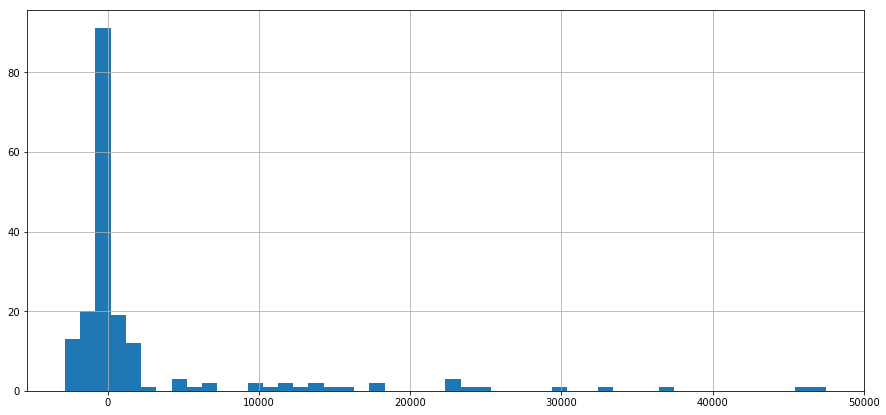

In [24]:
test_img_id = meta.iloc[:813]['image_id']
hist_mor_err()

### Evaluate on Cabauw

Below I test the generalisation performance of the model trained on De Bilt by evaluating its performance on the Cabauw test set.

In [25]:
predictions = bilt.predict(X_cab)
y_hat = [np.argmax(p) for p in predictions]
y_tr = [np.argmax(p) for p in y_cab]

print('Classification report:')
print(classification_report(y_pred=y_hat, y_true=y_tr))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=y_hat, y_true=y_tr))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=y_hat, y_true=y_tr))

Classification report:
             precision    recall  f1-score   support

          0       0.50      0.02      0.03       111
          1       0.24      0.04      0.07       162
          2       0.33      0.93      0.49       247
          3       0.64      0.11      0.19       256

avg / total       0.44      0.35      0.24       776


Confusion matrix:
[[  2  12  96   1]
 [  2   7 150   3]
 [  0   5 230  12]
 [  0   5 222  29]]

Accuracy:
0.345360824742


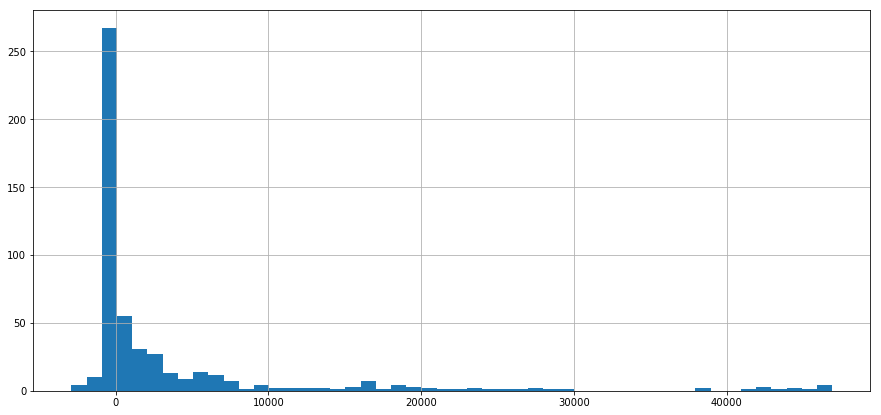

In [26]:
test_img_id = meta.iloc[813:]['image_id']
hist_mor_err()

As we can see the model does not generalize well if it is trained on De Bilt, but used to classify Cabauw instances. It seems to recognise a lot of Cabauw pictures as class B fog.

## Cabauw trained CNN
### Evaluate on Cabauw

The same evaluations are run for the Cabauw trained CNN

In [27]:
predictions = cab.predict(X_cab)
y_hat = [np.argmax(p) for p in predictions]
y_tr = [np.argmax(p) for p in y_cab]

print('Classification report:')
print(classification_report(y_pred=y_hat, y_true=y_tr))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=y_hat, y_true=y_tr))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=y_hat, y_true=y_tr))

Classification report:
             precision    recall  f1-score   support

          0       0.78      0.83      0.80       111
          1       0.82      0.62      0.70       162
          2       0.82      0.86      0.84       247
          3       0.85      0.92      0.88       256

avg / total       0.82      0.82      0.82       776


Confusion matrix:
[[ 92  14   4   1]
 [ 26 100  23  13]
 [  0   6 213  28]
 [  0   2  19 235]]

Accuracy:
0.824742268041


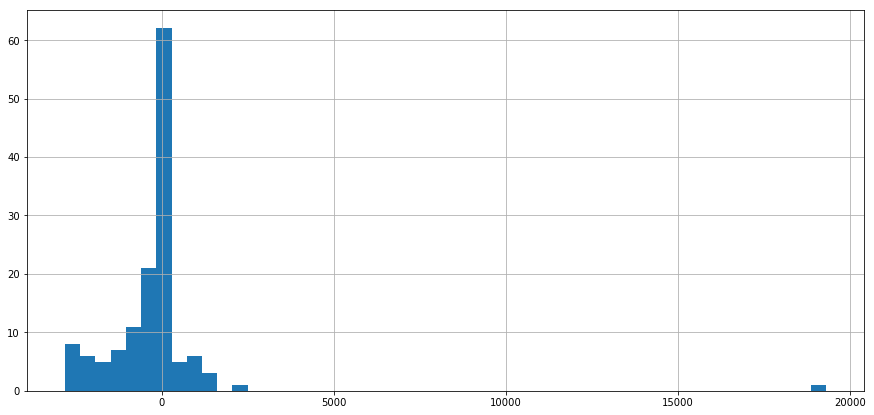

In [28]:
test_img_id = meta.iloc[813:]['image_id']
hist_mor_err()

Interesting to see the Cabauw trained model performs better, as I found it easier as a human to estimate fog density on De Bilt dataset. The CNN seems to prefer Cabauw. However, the skew of the errors is less favourable: it tends to underestimate fog density, leading to more dangerous scenarios as when it would overestimate the fog density. Penalising underestimation in the loss function could be a solution to this problem.

### Evaluate on De Bilt

In [29]:
predictions = cab.predict(X_bil)
y_hat = [np.argmax(p) for p in predictions]
y_tr = [np.argmax(p) for p in y_bil]

print('Classification report:')
print(classification_report(y_pred=y_hat, y_true=y_tr))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=y_hat, y_true=y_tr))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=y_hat, y_true=y_tr))

Classification report:
             precision    recall  f1-score   support

          0       1.00      0.01      0.03        67
          1       0.15      0.13      0.14        95
          2       0.25      0.04      0.06       241
          3       0.54      0.91      0.68       410

avg / total       0.45      0.49      0.38       813


Confusion matrix:
[[  1  32   6  28]
 [  0  12   7  76]
 [  0  15   9 217]
 [  0  22  14 374]]

Accuracy:
0.487084870849


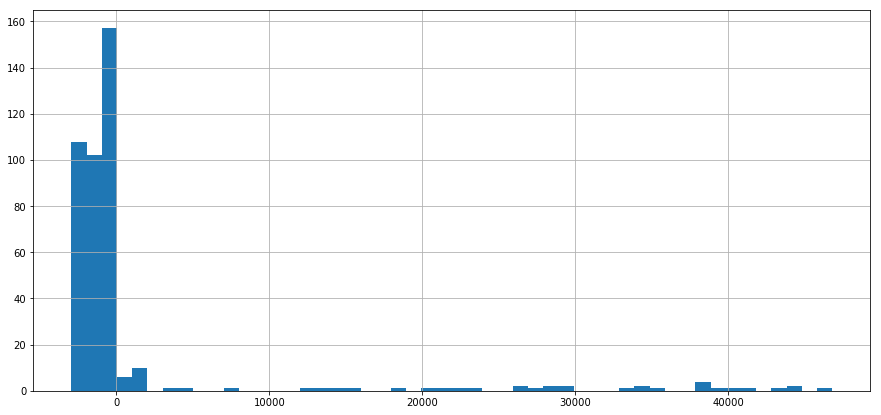

In [30]:
test_img_id = meta.iloc[:813]['image_id']
hist_mor_err()

The model trained on Cabauw suffers from the same lazy classification in generalisation as the De Bilt trained model. This time, class D is the common prediction. The classification performance in generalisation is not up to useful levels.

## CNN trained on full trainset (De Bilt + Cabauw)

Here I evaluate the performance of the network when it is trained on the full dataset, by predicting instances from the entire testset.

In [31]:
predictions = both.predict(X)
y_hat = [np.argmax(p) for p in predictions]
y_tr = [np.argmax(p) for p in y]

print('Classification report:')
print(classification_report(y_pred=y_hat, y_true=y_tr))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=y_hat, y_true=y_tr))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=y_hat, y_true=y_tr))

Classification report:
             precision    recall  f1-score   support

          0       0.78      0.78      0.78       178
          1       0.71      0.60      0.65       257
          2       0.77      0.76      0.76       488
          3       0.84      0.91      0.87       666

avg / total       0.79      0.80      0.79      1589


Confusion matrix:
[[138  30   8   2]
 [ 32 153  48  24]
 [  6  27 370  85]
 [  1   7  55 603]]

Accuracy:
0.795468848332


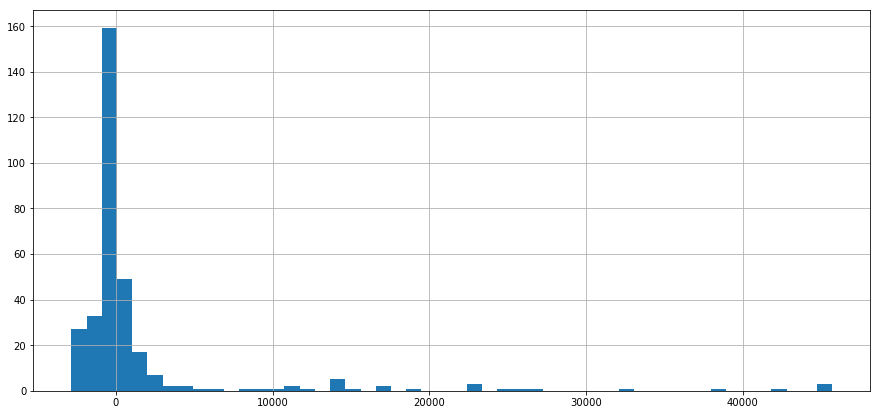

In [33]:
test_img_id = meta['image_id']
hist_mor_err()

## k-NN Algorithm Classification and Generalization Capacity

This block evaluates the generalization capacity of an unsupervised and 'naive' algorithm to see if CNN improve upon its score. We need to load the data again as we need the trainset as well and I heavily blur the images to aid the k-NN algorithm.

In [3]:
import scipy.stats

''' Specify the paths to the data.
'''
train_dir = '../data/Training/'
test_dir = '../../../thesis/Testing/'

''' Define helper functions.
'''
def process_img(path):
    return cv2.blur(cv2.resize(cv2.imread(path), (img_width, img_height), interpolation=cv2.INTER_LINEAR), (15, 15))

def load_data(data_dir):
    
    # get image metadata
    meta = pd.read_csv(data_dir + 'ImageDescription2.csv')
    imgID = meta['image_id'].values
    y = pd.Series(meta['vis_class']).astype('category', categories=list('ABCD')).cat.codes
    basenames = meta['basename'].values
    
    # preprocess images
    X = [process_img(glob.glob(os.path.join(data_dir, basename))[0]) for basename in basenames]
    X = np.array(X, dtype=np.uint8).astype('float32') / 255
    y = np_utils.to_categorical(np.array(y, dtype=np.uint8), 4)
    return X, y

def knn(xtrain, ytrain, xtest, k):
    res = []
    for img in xtest:
        dists = np.array([np.linalg.norm(img - train_img) for train_img in xtrain])
        res.append(scipy.stats.mode(ytrain[np.argsort(dists)[:k]])[0][0])
    return res

''' Load images, I use 224 (a bit smaller than CNN)
for limiting the computational complexity of the k-NN.
'''
img_width = img_height = 224

X, y = load_data(train_dir)
X_bil, y_bil = X[:2517], y[:2517]
X_cab, y_cab = X[2517:], y[2517:]

X_test, y_test = load_data(test_dir)
X_test_bil, y_test_bil = X_test[:813], y_test[:813]
X_test_cab, y_test_cab = X_test[813:], y_test[813:]

## k-NN with De Bilt reference set

### Evaluate on De Bilt

In [4]:
y_hat = knn(X_bil, y_bil, X_test_bil, 15)

preds = [np.argmax(y) for y in y_hat]
trues = [np.argmax(y) for y in y_test_bil]

print('Classification report:')
print(classification_report(y_pred=preds, y_true=trues))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=preds, y_true=trues))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=preds, y_true=trues))

Classification report:
             precision    recall  f1-score   support

          0       0.25      0.87      0.39        67
          1       0.63      0.18      0.28        95
          2       0.64      0.56      0.60       241
          3       0.89      0.75      0.81       410

avg / total       0.73      0.64      0.65       813


Confusion matrix:
[[ 58   2   7   0]
 [ 47  17  22   9]
 [ 71   5 134  31]
 [ 54   3  45 308]]

Accuracy:
0.635916359164


### Evaluate on Cabauw

In [5]:
y_hat = knn(X_bil, y_bil, X_test_cab, 15)

preds = [np.argmax(y) for y in y_hat]
trues = [np.argmax(y) for y in y_test_cab]

print('Classification report:')
print(classification_report(y_pred=preds, y_true=trues))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=preds, y_true=trues))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=preds, y_true=trues))

Classification report:
             precision    recall  f1-score   support

          0       0.26      0.09      0.13       111
          1       0.00      0.00      0.00       162
          2       0.77      0.04      0.08       247
          3       0.33      0.94      0.49       256

avg / total       0.39      0.34      0.21       776


Confusion matrix:
[[ 10   0   0 101]
 [  4   0   1 157]
 [ 12   0  10 225]
 [ 13   0   2 241]]

Accuracy:
0.336340206186


/home/daniel/miniconda3/envs/three/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## k-NN with Cabauw reference set

### Evaluate on Cabauw

In [6]:
y_hat = knn(X_cab, y_cab, X_test_cab, 15)

preds = [np.argmax(y) for y in y_hat]
trues = [np.argmax(y) for y in y_test_cab]

print('Classification report:')
print(classification_report(y_pred=preds, y_true=trues))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=preds, y_true=trues))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=preds, y_true=trues))

Classification report:
             precision    recall  f1-score   support

          0       0.63      0.86      0.73       111
          1       0.84      0.57      0.68       162
          2       0.76      0.83      0.79       247
          3       0.83      0.79      0.81       256

avg / total       0.78      0.77      0.77       776


Confusion matrix:
[[ 96  11   4   0]
 [ 37  92  23  10]
 [  6   3 205  33]
 [ 13   3  37 203]]

Accuracy:
0.768041237113


### Evaluate on De Bilt

In [7]:
y_hat = knn(X_cab, y_cab, X_test_bil, 15)

preds = [np.argmax(y) for y in y_hat]
trues = [np.argmax(y) for y in y_test_bil]

print('Classification report:')
print(classification_report(y_pred=preds, y_true=trues))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=preds, y_true=trues))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=preds, y_true=trues))

Classification report:
             precision    recall  f1-score   support

          0       0.08      1.00      0.16        67
          1       0.00      0.00      0.00        95
          2       0.13      0.01      0.02       241
          3       0.00      0.00      0.00       410

avg / total       0.05      0.08      0.02       813


Confusion matrix:
[[ 67   0   0   0]
 [ 95   0   0   0]
 [237   2   2   0]
 [396   1  13   0]]

Accuracy:
0.0848708487085


/home/daniel/miniconda3/envs/three/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## k-NN with entire trainset as reference

### Evaluate on entire testset

In [8]:
y_hat = knn(X, y, X_test, 15)

preds = [np.argmax(y) for y in y_hat]
trues = [np.argmax(y) for y in y_test]

print('Classification report:')
print(classification_report(y_pred=preds, y_true=trues))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_pred=preds, y_true=trues))
print('')
print('Accuracy:')
print(accuracy_score(y_pred=preds, y_true=trues))

Classification report:
             precision    recall  f1-score   support

          0       0.40      0.87      0.55       178
          1       0.80      0.42      0.55       257
          2       0.71      0.69      0.70       488
          3       0.86      0.77      0.81       666

avg / total       0.75      0.70      0.71      1589


Confusion matrix:
[[154  13  11   0]
 [ 84 109  45  19]
 [ 77   8 339  64]
 [ 67   6  82 511]]

Accuracy:
0.700440528634


While it seems that k-NN can work quite well without domain shift (especially for these datasets, where the camera is fixed and generally the pixels are the same across the images), the CNN tend to outperform them. The error distribution (as can be seen from the confusion matrices) indicate that the errors made are a bit more haphazard than those made by the CNN. Moreover, k-NN is not suitable for generalization, as the metrics indicate poor performance.